# `F = ma` - with activation

In [1]:
import torch
from torch import nn
from torch.optim import Adam
from matplotlib import pyplot as plt
import pandas as pd
from tqdm.notebook import tqdm
import numpy as np

## Model

Keeping this extremely simple

In [2]:
class LinearLayer(nn.Module):
    def __init__(self, in_feats, out_feats, use_act=True, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.linear = nn.Linear(in_feats, out_feats)
        self.act = nn.ReLU()
        self.use_act = use_act

    def forward(self, x):
        x = self.linear(x)
        if self.use_act:
            x = self.act(x)
        return x


class Net(nn.Module):
    def __init__(self, use_act=True, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.layer = LinearLayer(2, 1, use_act=use_act)

    def forward(self, x):
        return self.layer(x)

## Data

Also keeping this extremely simple

In [3]:
X = torch.rand(10000, 2)  # mass and acceleration respectively
Y = X[:, 0] * X[:, 1]  # force = mass * acceleration
Y = Y[:, None]
X.shape, Y.shape

(torch.Size([10000, 2]), torch.Size([10000, 1]))

In [4]:
s_inds = np.random.permutation(range(X.shape[0]))  # shuffled indices

X_train = X[s_inds[:8000]]
Y_train = Y[s_inds[:8000]]
X_valid = X[s_inds[8000:]]
Y_valid = Y[s_inds[8000:]]

X_train.shape, Y_train.shape, X_valid.shape, Y_valid.shape

(torch.Size([8000, 2]),
 torch.Size([8000, 1]),
 torch.Size([2000, 2]),
 torch.Size([2000, 1]))

## Training

I'll just do full gradient descent to keep things simple.

In [5]:
N = 100  # number of epochs

model = Net(use_act=True)
loss_func = nn.MSELoss()
optimiser = Adam(model.parameters(), lr=1e-1)
log = []

for i in tqdm(range(N)):
    log_sample = {}

    # Training update
    model.train()
    model.zero_grad()
    Y_hat = model(X_train)
    loss = loss_func(Y_hat, Y_train)
    log_sample["train_loss"] = float(loss.detach())
    loss.backward()
    optimiser.step()

    # Validation set
    model.eval()
    Y_hat = model(X_valid)
    loss = loss_func(Y_hat, Y_valid)
    log_sample["valid_loss"] = float(loss.detach())

    log.append(log_sample)

df = pd.DataFrame(log)

  0%|          | 0/100 [00:00<?, ?it/s]

## Results

In [6]:
def plot_loss(train_loss, valid_loss):
    _, ax = plt.subplots()

    ax.plot(train_loss, label="train")
    ax.plot(valid_loss, label="valid")
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Loss")
    ax.legend()


def get_preds(model):
    with torch.inference_mode():
        out = model(X_valid)

    y_preds = out.flatten().numpy()
    y_targs = Y_valid.flatten().numpy()

    return y_preds, y_targs


def get_valid_loss(model):
    model.eval()

    with torch.inference_mode():
        out = model(X_valid)

    return loss_func(out, Y_valid)


def plot_results(y_preds, y_targs):
    _, ax = plt.subplots()

    ax.scatter(y_preds, y_targs, s=4, label="predictions")
    ax.plot(y_targs, y_targs, color="salmon", ls="--", lw=0.5, label="perfect accuracy")
    ax.set(xlabel="y_preds", ylabel="y_targs")
    ax.legend()

Did a bit of HP tuning to get to this thing which looks like it's converged. Looks funky though 🤔

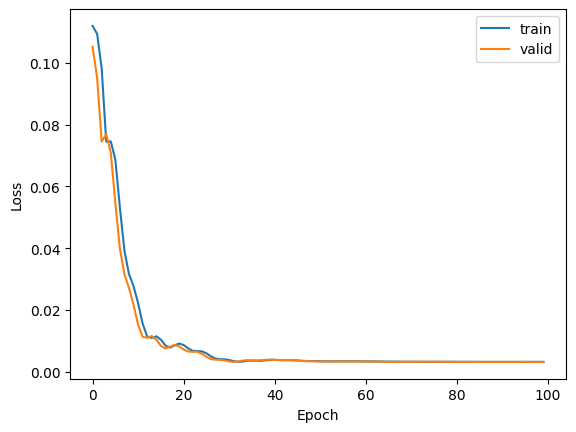

In [7]:
plot_loss(df["train_loss"], df["valid_loss"])

In [8]:
y_preds, y_targs = get_preds(model)

In [9]:
get_valid_loss(model)

tensor(0.0032)

Just with the non-linearity, we can get to roughly half the loss of the previous model (which just had a simple linear operation).

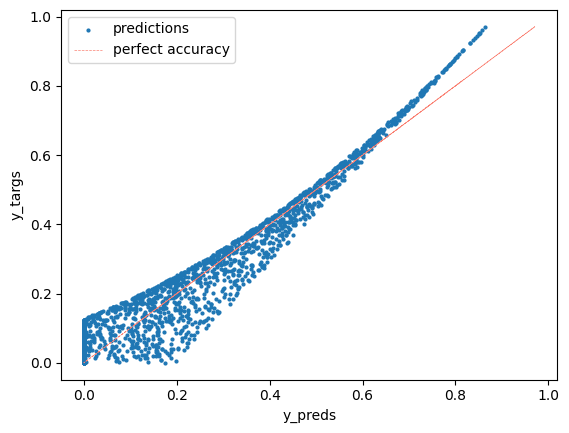

In [10]:
plot_results(y_preds, y_targs)

Ok it looks half decent. Let's have a look now at the layers to see if it makes sense.

## Introspection

In [11]:
model

Net(
  (layer): LinearLayer(
    (linear): Linear(in_features=2, out_features=1, bias=True)
    (act): ReLU()
  )
)

In [12]:
W, b = list(model.layer.linear.parameters())
W, b

(Parameter containing:
 tensor([[0.6836, 0.6905]], requires_grad=True),
 Parameter containing:
 tensor([-0.4898], requires_grad=True))

We've now moved away from nice round numbers.

In [13]:
def get_preds_range(x2=0.5):
    # True solution
    x1 = np.linspace(0, 1, 50)
    x2 = np.repeat(x2, 50)
    y = x1 * x2

    # Predicted solution
    with torch.inference_mode():
        x = torch.stack([torch.as_tensor(x1), torch.as_tensor(x2)]).T.float()
        y_hat = model(x)
        y_hat = y_hat.detach().numpy()

    return y_hat, y


def get_preds_multi_range():
    x2s = np.linspace(0, 1, 11)
    rows = []
    for x2 in x2s:
        row = {"x2": x2}
        row["y_hat"], row["y"] = get_preds_range(x2=x2)
        rows.append(row)
    return rows

In [14]:
results = get_preds_multi_range()

Fixing $x_2$ and varying $x_1$ to isolate behaviour:

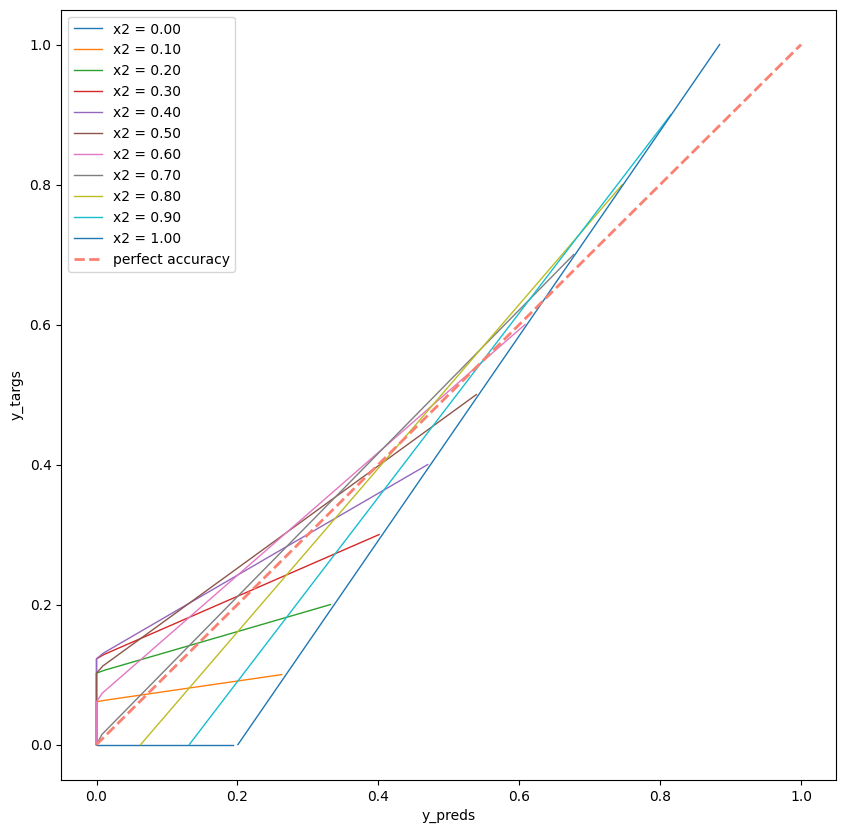

In [15]:
fig, ax = plt.subplots(figsize=(10, 10))

for row in results:
    ax.plot(row["y_hat"], row["y"], lw=1, label=f"x2 = {row['x2']:.2f}")

ax.plot([0, 1], [0, 1], color="salmon", lw=2, ls="--", label="perfect accuracy")
ax.set(xlabel="y_preds", ylabel="y_targs")
ax.legend()